
# PET TOF listmode projector

In this example we will show how to setup and use a TOF 
PET listmode projector including geometrical forward projection
in listmode, image-based resolution model and a listmode 
attenuation model.

.. tip::
    parallelproj is python array API compatible meaning it supports different 
    array backends (e.g. numpy, cupy, torch, ...) and devices (CPU or GPU).
    Choose your preferred array API ``xp`` and device ``dev`` below.

<img src="https://mybinder.org/badge_logo.svg" target="https://mybinder.org/v2/gh/gschramm/parallelproj/master?labpath=examples">


In [1]:
# import array_api_compat.numpy as xp
import array_api_compat.cupy as xp
# import array_api_compat.torch as xp
import parallelproj
from array_api_compat import to_device
import array_api_compat.numpy as np
import matplotlib.pyplot as plt

# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    dev = "cuda"


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /home/pablo/anaconda3/envs/recon/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /home/pablo/anaconda3/envs/recon/lib/libparallelproj_cuda.so.1.8.0
    


setup a regular polygon PET scanner



In [2]:
# Create a Quadra PET scanner
num_rings = 320
radius = 410.0  #mm
max_z = 530.0
### create a reduced Quadra PET scanner
original_max_z = max_z
max_z = 240.0
num_rings = int(num_rings * max_z / original_max_z)
###


# Create a Vision PET scanner
# num_rings = 80
# max_z = 131.15
num_sides = 760
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=radius,
    num_sides=num_sides,
    num_lor_endpoints_per_side=1,
    lor_spacing=0.4,
    ring_positions=xp.linspace(-max_z, max_z, num_rings),
    symmetry_axis=1,
)

# Image parameters
img_shape = (248, 140, 176)  # for head and neck
voxel_size = (1.9531, 1.9531, 1.5)  # for head and neck

# TOF
TOF_resolution = 225
tofbin_FWHM = TOF_resolution * 1e-12 * 3e8 / 2 *1e3 # *1e3 to mm;  *1e-12 to s; *3e8 to m/s;  /2 to get one-way distance;
sigma_tof = tofbin_FWHM / 2.355 # to get sigma from FWHM
tofbin_width = sigma_tof * 1.03  # sigma_tof * 1.03, as given in https://parallelproj.readthedocs.io/en/stable/python_api.html#module-parallelproj.tof # ps, it is the minimum time difference between the arrival of two photons that it can detect. it is diveded by 2 because if one of them arrivs TOF_resolution


In [3]:
import pandas as pd
import struct

# Define the path to your binary .raw file
psf_path = '/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/quadra_head_simulation/MCGPU_PET.psf.raw'

# Define the structure format for one data record
format_string = 'Q f i f f f f f f h h'
record_size = struct.calcsize(format_string)

# Define the dtype for numpy based on the format string
dtype = np.dtype([
    ('emission_time', 'u8'), # unsigned long long int (Q) (emission_time (ps))
    ('travel_time', 'f4'),   # float (f) (travel_time (ps))
    ('emission_voxel', 'i4'),# int (i) (emission voxel)
    ('energy', 'f4'),        # float (f) (energy)
    ('z', 'f4'),             # float (f) (z (cm))
    ('phi', 'f4'),           # float (f) (phi (rad))
    ('vx', 'f4'),            # float (f) (vx; x component of the incident photon direction)
    ('vy', 'f4'),            # float (f) (vy; y component of the incident photon direction)
    ('vz', 'f4'),            # float (f) (vz; z component of the incident photon direction)
    ('index1', 'i2'),        # short int (h)  Flag for scatter: =0 for non-scattered, =1 for Compton, =2 for Rayleigh, and =3 for multiple scatter)
    ('index2', 'i2')         # short int (h) (index2)
])

# Read the binary file in chunks and convert directly to DataFrame
chunk_size = 100000 
events = []

with open(psf_path, 'rb') as file:
    while True:
        data = file.read(record_size * chunk_size)
        if not data:
            break
        
        chunk = np.frombuffer(data, dtype=dtype)
        
        event = pd.DataFrame(chunk).loc[:, ['travel_time','z', 'phi']]
        events.append(event)

events = pd.concat(events, ignore_index=True)


In [4]:
# Display the first few rows of the DataFrame
events_x = radius * np.cos(events.phi)  # x position of the detector
events_y = radius * np.sin(events.phi)  # y position of the detector
events_z = events.z * 10.0  # cm to mm
bin = np.round((events.travel_time.iloc[0::2].values - events.travel_time.iloc[1::2].values) / (TOF_resolution / 2.355 * 1.03)).astype(int)  # / 2.355 * 1.03 to match the spatial tof_bin width
bin = xp.repeat(bin, 2)
del events

# If outputting scatters, remove events with index1 != 0 and their corresponding antiparallel events (row above if uneven index1, row below if even index1)
# events['photon_pairs'] = events.index // 2
# scattered_pairs = events[events['index1'] != 0]['photon_pairs'].unique()
# events = events[~events['photon_pairs'].isin(scattered_pairs)]
# events = events.drop(columns='photon_pairs')

event_start_coordinates = xp.asarray(np.stack((events_x.iloc[0::2].values, events_y.iloc[0::2].values, events_z.iloc[0::2].values), axis=1), device=dev)
event_end_coordinates = xp.asarray(np.stack((events_x.iloc[1::2].values, events_y.iloc[1::2].values, events_z.iloc[1::2].values), axis=1), device=dev)

event_tof_bins = xp.asarray(bin[0::2], device=dev)
num_tofbins = xp.max(xp.abs(event_tof_bins)) * 2 + 1
if num_tofbins % 2 == 0:
    num_tofbins -= 1
print("num_tofbins", num_tofbins)

tof_params = parallelproj.TOFParameters(
    sigma_tof=sigma_tof, num_tofbins=num_tofbins, tofbin_width=tofbin_width
)

# # count unique values
# unique, counts = np.unique(bin, return_counts=True)
# print(dict(zip(unique, counts)))


num_tofbins 37


## Show the scanner geometry and the events



In [5]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection="3d")
# scanner.show_lor_endpoints(ax)
# for i in range(event_start_coordinates.shape[0]):
#     ax.plot(
#         [float(event_start_coordinates[i, 0]), float(event_end_coordinates[i, 0])],
#         [float(event_start_coordinates[i, 2]), float(event_end_coordinates[i, 2])],
#         [float(event_start_coordinates[i, 1]), float(event_end_coordinates[i, 1])],
#     )
#     print(event_start_coordinates[i], event_end_coordinates[i])
#     if i == 2:
#         break

# ax.view_init(elev=0, azim=90)
# fig.tight_layout()


## Setup a TOF listmode projector


In [6]:
lor_desc = parallelproj.RegularPolygonPETLORDescriptor(
    scanner,
    radial_trim=1,
    max_ring_difference=3,
    span=1,  ##11
    sinogram_order=parallelproj.SinogramSpatialAxisOrder.RVP,
)

proj = parallelproj.RegularPolygonPETProjector(
    lor_desc, img_shape=img_shape, voxel_size=voxel_size
)

enable_tof = False
if enable_tof:
    proj.tof_parameters = tof_params

###
# setup an attenuation (mu, units in 1/mm) image containing the attenuation coeff
mu_pet_water = 0.0096
mu_pet_bone = 0.0172
mu_ct_water = 0.0184
mu_ct_bone = 0.0428
CT = xp.load("/home/pablo/prototwin/deep-learning-dose-activity-dictionary/data/head-sobp-dataset3/CT_uncropped.npy")

def CT_to_attenuation(CT):
    CT_smaller_zero = mu_pet_water * (CT + 1000) / 1000
    CT_larger_zero = mu_pet_water + CT * mu_ct_water * (mu_pet_bone - mu_pet_water) / 1000 / (mu_ct_bone - mu_pet_water)
    mask = CT > 0
    mu_PET = xp.where(mask, CT_larger_zero, CT_smaller_zero)
    return mu_PET

x_att = CT_to_attenuation(CT)
del CT
# x_att = xp.full(proj.in_shape, mu_pet_water, device=dev, dtype=xp.float32)  # to get a uniform attenuation
x_att_fwd = proj(x_att)
# del x_att
# calculate the attenuation sinogram
att_sino = xp.exp(-x_att_fwd)
del x_att_fwd


att_op = parallelproj.ElementwiseMultiplicationOperator(att_sino)

###

res_model = parallelproj.GaussianFilterOperator(
    proj.in_shape, sigma=3.5 / (2.35 * proj.voxel_size)
)

# compose all 3 operators into a single linear operator
pet_lin_op = parallelproj.CompositeLinearOperator((
    # att_op,  ###
    proj, res_model))

print(pet_lin_op.out_shape)

# Best option: Importing sensibility for the CT instead of finding adjoint_ones
import gzip 
file_path = '/home/pablo/prototwin/deep-learning-dose-activity-dictionary/pet-simulation-reconstruction/mcgpu-pet/sensibility_uniform_head_simulation/image_Trues.raw.gz'
with gzip.open(file_path, 'rb') as f:
    adjoint_ones = xp.frombuffer(f.read(), dtype=np.int32).reshape(img_shape, order='F')
adjoint_ones[adjoint_ones<1] = 1  # to avoid dividing by zero, only happens at the edge of FOV
adjoint_ones = adjoint_ones + 1000 * adjoint_ones.mean()


# # Slower option: finding adjoint_ones for the sensibility
# adjoint_ones = pet_lin_op.adjoint(
#     xp.ones(pet_lin_op.out_shape, dtype=xp.float32, device=dev)  
# )


(759, 380, 996)


In [7]:
print(adjoint_ones.min(), adjoint_ones.max(), adjoint_ones.mean())

1689.4604432865522 1715.4604432865522 1690.1489037298388


In [8]:
# # Let's see how adjoint_ones looks like
# adjoint_ones = adjoint_ones == 0
# plt.imshow(adjoint_ones[:,21,:].get(), cmap='jet')
# plt.colorbar()
# print(adjoint_ones.min(), adjoint_ones.mean(), adjoint_ones.max())

In [9]:
lm_proj = parallelproj.ListmodePETProjector(
    event_start_coordinates, event_end_coordinates, img_shape, voxel_size
)

if enable_tof:
    lm_proj.tof_parameters = tof_params
    lm_proj.event_tofbins = event_tof_bins
    lm_proj.tof = enable_tof

print(f"proj output shape {lm_proj.out_shape}")

proj output shape (42211045,)


In [10]:
num_subsets = 2
subset_slices = [slice(i, None, num_subsets) for i in range(num_subsets)]

lm_pet_subset_linop_seq = []

for i, sl in enumerate(subset_slices):
    subset_lm_proj = parallelproj.ListmodePETProjector(
        event_start_coordinates[sl, :], event_end_coordinates[sl, :], img_shape, voxel_size
    )

    # enable TOF in the LM projector
    subset_lm_proj.tof_parameters = lm_proj.tof_parameters
    if lm_proj.tof:
        # we need to make a copy of the 1D subset event_tofbins array
        # stupid way of doing this, but torch asarray copy doesn't seem to work
        subset_lm_proj.event_tofbins = 1 * event_tof_bins[sl]
        subset_lm_proj.tof = lm_proj.tof

    ###
    subset_att_list = xp.exp(-subset_lm_proj(x_att))
    subset_lm_att_op = parallelproj.ElementwiseMultiplicationOperator(subset_att_list)
    ###
    
    lm_pet_subset_linop_seq.append(
        parallelproj.CompositeLinearOperator((
            # subset_lm_att_op, subset_lm_proj, res_model)
            # subset_lm_att_op,
            subset_lm_proj, res_model)
        )
    )

lm_pet_subset_linop_seq = parallelproj.LinearOperatorSequence(lm_pet_subset_linop_seq)


In [11]:
def lm_em_update(x_cur, op, adjoint_ones):
    """LM EM update

    Parameters
    ----------
    x_cur : Array
        current solution
    op : parallelproj.LinearOperator
        subset listmode linear forward operator
    adjoint_ones : Array
        adjoint of ones of the non-LM (the complete) operator
        divided by the number of subsets

    Returns
    -------
    Array
        _description_
    """
    epsilon = 1e-10  #  If ybar contains zeros, dividing by it can produce NaNs
    ybar = op(x_cur)
    x = x_cur * op.adjoint(1 / (ybar + epsilon)) / adjoint_ones
    # x = (1-beta)*x + beta*medianfilter(x)  # one step late regularization
    return x

In [12]:
import array_api_compat.torch as torch
import torch.nn.functional as F
# from scipy.ndimage import median_filter
import cupy as cp
from cupyx.scipy.ndimage import median_filter
import math

# regularized mlem: https://downloads.hindawi.com/journals/mpe/2014/491239.pdf?_gl=1*qw2bn9*_ga*MTkxNDI0Mzc1MC4xNzE2NTY0Nzg2*_ga_NF5QFMJT5V*MTcxNjU2NDc4NS4xLjAuMTcxNjU2NDc4NS42MC4wLjA.&_ga=2.3863920.199569902.1716564786-1914243750.1716564786
def g(x, K):
    sqrt_5K = (5 ** 0.5) * K
    result = torch.zeros_like(x)
    mask = torch.abs(x) <= sqrt_5K
    result[mask] = (25 / (16 * K)) * (1 - (x[mask] / sqrt_5K) ** 2) ** 2
    return result

def mlem_pde_update(x_cur, op, adjoint_ones, w=1.0, K="MAD", kernel_size=3):
    epsilon = 1e-10  #  If ybar contains zeros, dividing by it can produce NaNs
    ybar = op(x_cur)
    x = x_cur * op.adjoint(1 / (ybar + epsilon)) / adjoint_ones
    
    x = torch.tensor(x, device='cuda').unsqueeze(0)
    pad = kernel_size // 2
    x_padded = F.pad(x.unsqueeze(0), (pad, pad, pad, pad, pad, pad), mode='replicate').squeeze(1)
    # Unfolding to extract the neighbours in each dimension
    x_unfolded = x_padded.unfold(1, kernel_size, 1).unfold(2, kernel_size, 1).unfold(3, kernel_size, 1)  # 5 for the first dim because it is in length of 1 mm
    x_unfolded = x_unfolded.flatten(start_dim=1, end_dim=3).flatten(start_dim=2, end_dim=4).squeeze(0)  # flattening the spatial dimensions

    # finding the values in the target vector larger than a certain threshold wrt the max
    x_flat = x.flatten(start_dim=1, end_dim=3).squeeze(0).unsqueeze(-1)
    grad_f = x_flat - x_unfolded
    if K == "MAD":
        K = 1.4826 * torch.median(torch.abs(grad_f - torch.median(grad_f)))  # Black et al., https://en.wikipedia.org/wiki/Median_absolute_deviation
    elif K == "MEAN":
        K = torch.mean(torch.abs(grad_f))  # Torkamani-Azar and Tait
    # K = 1.5  # given in the paper
    reg_term = 1 / (kernel_size ** len(img_shape)) * torch.sum(g(torch.abs(grad_f), K) * grad_f, dim=1).reshape(img_shape)
    x = x + reg_term * w
    x = xp.asarray(x.squeeze(0), device=dev)   
    x = median_filter(x, size=kernel_size)
    return x

In [13]:
# test_img_shape = (4, 4, 4)###

# # Make a 4d array of values going from 1 to size(x)
# x = torch.arange(math.prod(test_img_shape)).reshape(test_img_shape).unsqueeze(0).type(torch.float32)
# x_padded = F.pad(x.unsqueeze(1), (1, 1, 1, 1, 1, 1), mode='replicate').squeeze(1)
# # Unfolding to extract the neighbours in each dimension
# x_unfolded = x_padded.unfold(1, kernel_size, 1).unfold(2, kernel_size, 1).unfold(3, kernel_size, 1)  # 5 for the first dim because it is in length of 1 mm
# x_unfolded = x_unfolded.flatten(start_dim=1, end_dim=3).flatten(start_dim=2, end_dim=4).squeeze(0)  # flattening the spatial dimensions

# # finding the values in the target vector larger than a certain threshold wrt the max
# x_flat = x.flatten(start_dim=1, end_dim=3).squeeze(0).unsqueeze(-1)
# grad_f = x_flat - x_unfolded
# w = 1.0
# # K = torch.mean(torch.abs(grad_f))  # Torkamani-Azar and Tait
# K = 1.5  # given in the paper
# # K = 1.4826 * torch.median(torch.abs(grad_f - torch.median(grad_f)))  # Black et al., https://en.wikipedia.org/wiki/Median_absolute_deviation

# # print(x_flat.shape, x_unfolded.shape)
# # print((x_flat - x_unfolded).shape)
# # print((x_flat - x_unfolded)[21])
# # print(torch.sum(g(torch.abs(grad_f), K) * grad_f, dim=1).reshape(img_shape).shape)

# reg_term = w / (kernel_size ** len(img_shape)) * torch.sum(g(torch.abs(grad_f), K) * grad_f, dim=1).reshape(img_shape)

# print(median_filter(reg_term, size=3).shape)


In [14]:
# number of MLEM iterations
num_iter = 6

x = xp.ones(img_shape, dtype=xp.float32, device=dev)
adjoint_ones = to_device(xp.asarray(adjoint_ones, dtype=xp.float32), dev)

x_list = []
# w = 0.5  ###
for i in range(num_iter):
    for k, sl in enumerate(subset_slices):
        print(f"OSEM iteration {(k+1):03} / {(i + 1):03} / {num_iter:03}", end="\r")
        # w = w * 0.5 ###
        x = lm_em_update(
        # x = mlem_pde_update(
            x,
            lm_pet_subset_linop_seq[k],
            adjoint_ones / num_subsets,
            # w=w, K=1.5, kernel_size = 3
        )
        x_list.append(x.get())

0.0 3.0419474


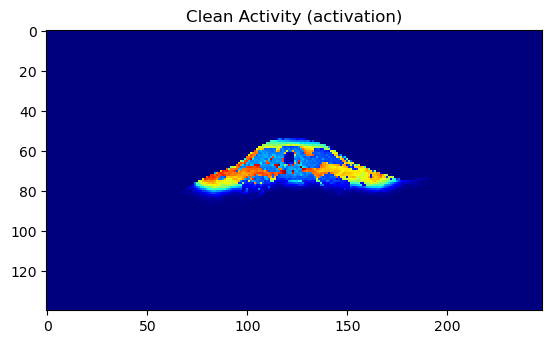

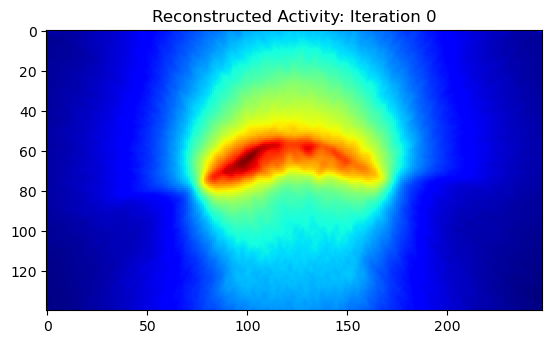

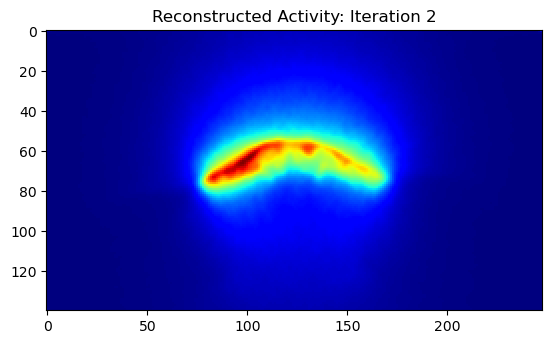

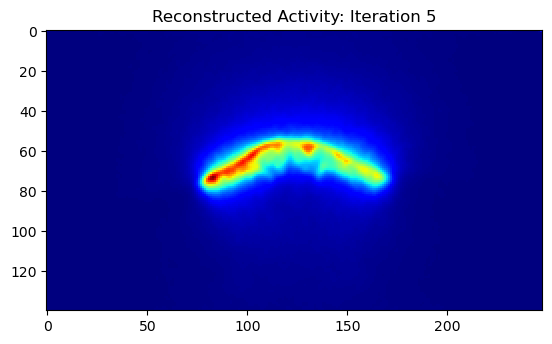

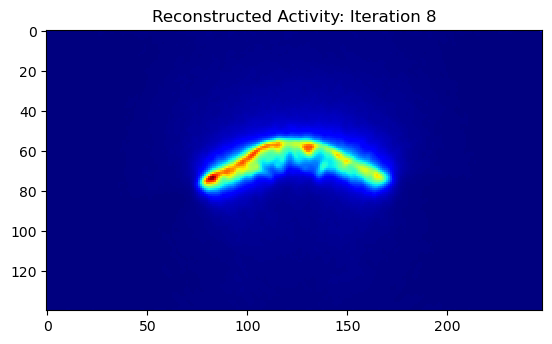

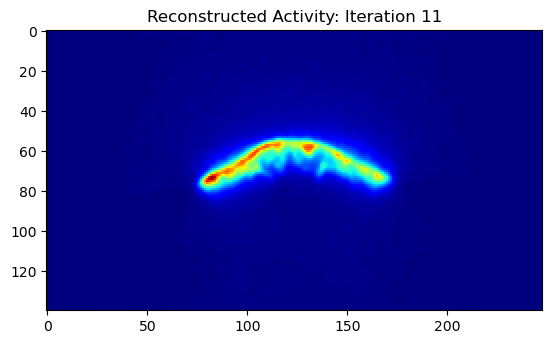

In [15]:
import os
dtype = np.float32
# npy_location = os.path.join("/home/pablo/prototwin/deep-learning-dose-activity-dictionary/data/sobp-dataset6/activation_uncropped")
dataset_num = 3
npy_location = os.path.join(f"/home/pablo/prototwin/deep-learning-dose-activity-dictionary/data/head-sobp-dataset{dataset_num}/activation_uncropped")

activation = np.load(npy_location + "/sobp0.npy")
# activation = activation.astype(int)
activation = xp.asarray(activation, dtype=dtype)
activation = to_device(activation, dev)
print(activation.min(), activation.max())
# Plot the activity image above and the x image below
z_slice = activation.shape[2] // 2 - 30

activation_arr = activation.get()
activation_normalized = (activation_arr - activation_arr.min()) / (activation_arr.max() - activation_arr.min())

plt.figure()
plt.imshow(activation_normalized[:, :, z_slice].T, cmap="jet")
plt.title("Clean Activity (activation)")

num_plots = 5

for iter in np.linspace(0, len(x_list) - 1, num_plots, dtype=int):
    x_normalized = (x_list[iter] - x_list[iter].min()) / (x_list[iter].max() - x_list[iter].min())
    plt.figure()
    plt.imshow(x_normalized[:, :, z_slice].T, cmap="jet")
    plt.title(f"Reconstructed Activity: Iteration {iter}")   

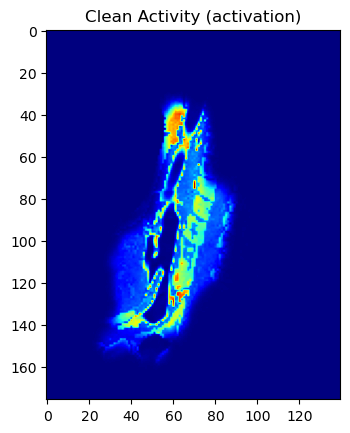

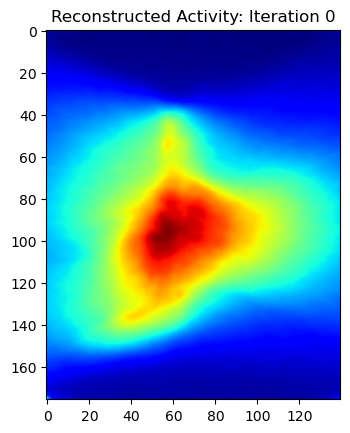

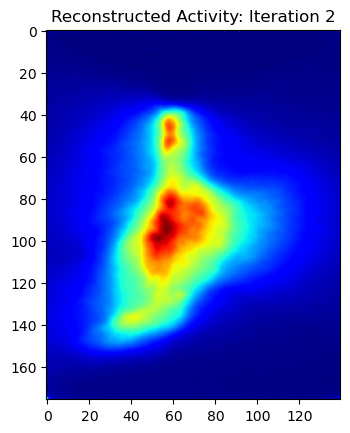

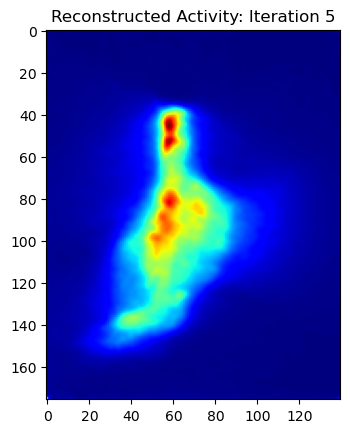

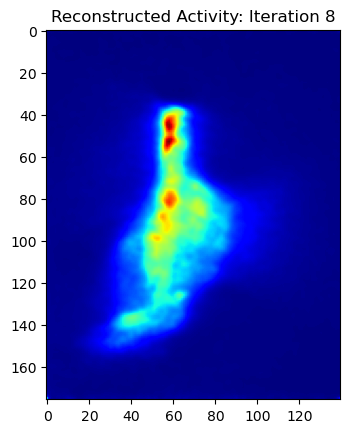

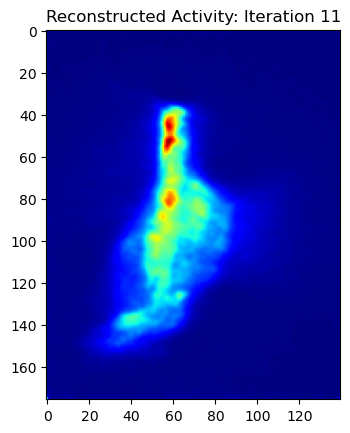

In [16]:
x_slice = activation.shape[0] // 2

plt.figure()
plt.imshow(activation_normalized[x_slice, :, :].T, cmap="jet")
plt.title("Clean Activity (activation)")

num_plots = 5

for iter in np.linspace(0, len(x_list) - 1, num_plots, dtype=int):
    x_normalized = (x_list[iter] - x_list[iter].min()) / (x_list[iter].max() - x_list[iter].min())
    plt.figure()
    plt.imshow(x_normalized[x_slice, :, :].T, cmap="jet")
    plt.title(f"Reconstructed Activity: Iteration {iter}")   

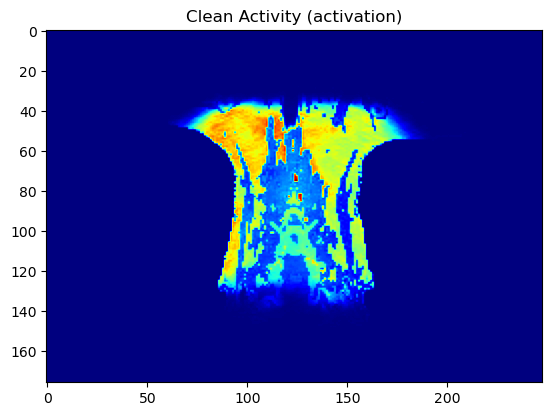

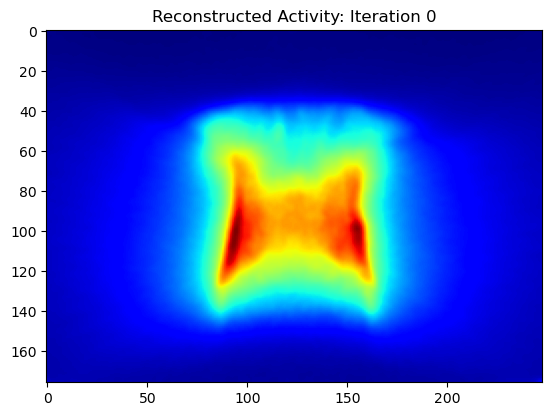

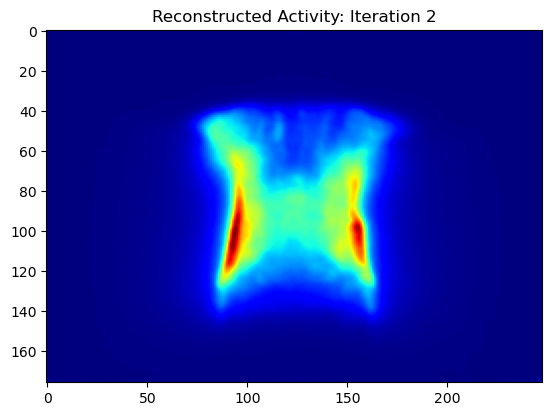

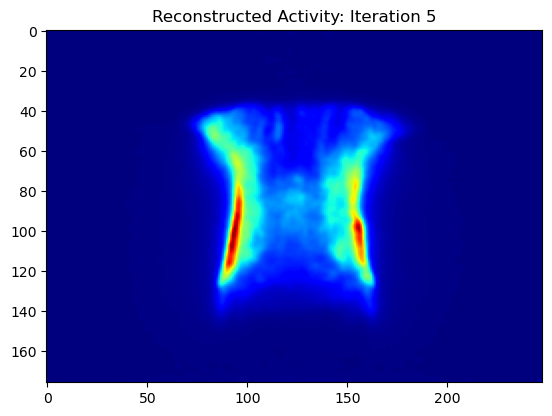

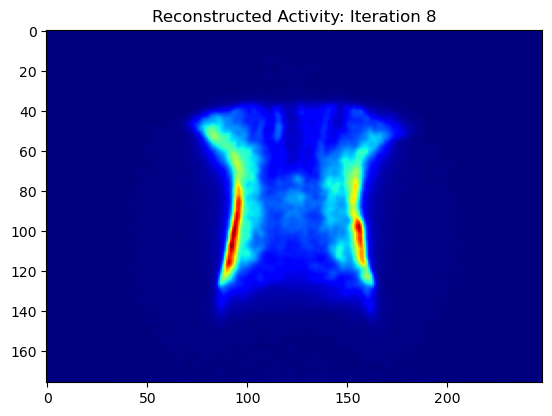

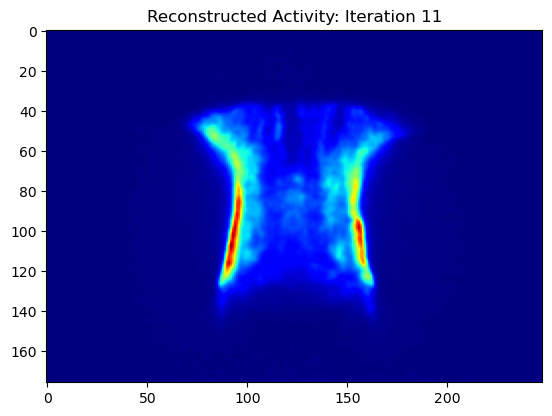

In [17]:
y_slice = activation.shape[1] // 2

plt.figure()
plt.imshow(activation_normalized[:, y_slice, :].T, cmap="jet")
plt.title("Clean Activity (activation)")

num_plots = 5

for iter in np.linspace(0, len(x_list) - 1, num_plots, dtype=int):
    x_normalized = (x_list[iter] - x_list[iter].min()) / (x_list[iter].max() - x_list[iter].min())
    plt.figure()
    plt.imshow(x_normalized[:, y_slice, :].T, cmap="jet")
    plt.title(f"Reconstructed Activity: Iteration {iter}")   

Best MSE at iteration 7 with value 0.0021720007061958313
Best SSIM at iteration 11 with value 0.8392896935241378
Best PSNR at iteration 7 with value 26.63140058517456
Elbow point is at iteration 2 with metric value 0.00352289667353034
Elbow point is at iteration 3 with metric value 0.6898815561025764
Elbow point is at iteration 3 with metric value 25.78263521194458


Text(0, 0.5, 'Metrics')

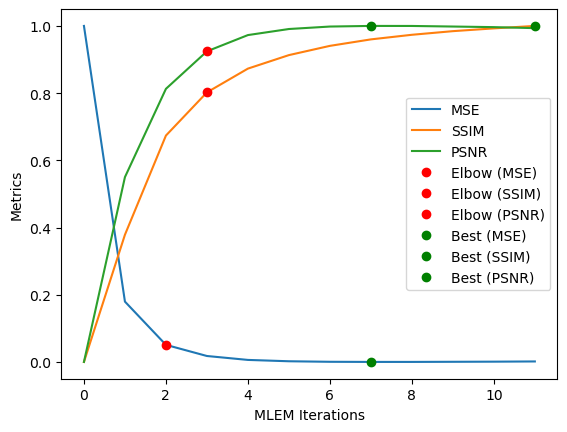

: 

In [18]:
# Find elbow
from skimage.metrics import structural_similarity as ssim

def mse_loss(array1, array2):
    return np.mean((array1 - array2) ** 2)# Find elbow
def mae_loss(array1, array2):
    return np.mean(np.abs(array1 - array2))
def psnr_loss(array1, array2):
    mse = mse_loss(array1, array2)
    if mse == 0:
        return float('inf')
    max_pixel = array1.max()  # Adjust based on your image data range
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

mse_loss_array = []
ssim_loss_array = []
psnr_loss_array = []


for i, x in enumerate(x_list):
    x_normalized = (x - x.min()) / (x.max() - x.min())
    mse_loss_array.append(mse_loss(x_normalized, activation_normalized))
    ssim_loss_array.append(ssim(x_normalized, activation_normalized, data_range=1.0))
    psnr_loss_array.append(psnr_loss(x_normalized, activation_normalized))

mse_loss_array = np.array(mse_loss_array)
ssim_loss_array = np.array(ssim_loss_array)
psnr_loss_array = np.array(psnr_loss_array)

# Print best metric iterations
best_mse = np.argmin(mse_loss_array)
print(f"Best MSE at iteration {best_mse} with value {mse_loss_array[best_mse]}")
best_ssim = np.argmax(ssim_loss_array)
print(f"Best SSIM at iteration {best_ssim} with value {ssim_loss_array[best_ssim]}")
best_psnr = np.argmax(psnr_loss_array)
print(f"Best PSNR at iteration {best_psnr} with value {psnr_loss_array[best_psnr]}")

# Print elbow 
# Function to calculate distance from a point to a line (given by two points)
def point_line_distance(point, line_start, line_end):
    return np.abs(np.cross(line_end-line_start, line_start-point)) / np.linalg.norm(line_end-line_start)
mlem_iterations = np.arange(len(x_list))
#MSE
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], mse_loss_array[0]])
line_end = np.array([mlem_iterations[-1], mse_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, mse_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_mse= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_mse} with metric value {mse_loss_array[elbow_mse]}")
#SSIM
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], ssim_loss_array[0]])
line_end = np.array([mlem_iterations[-1], ssim_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, ssim_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_ssim= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_ssim} with metric value {ssim_loss_array[elbow_ssim]}")
#PSNR
# Coordinates of the first and last points
line_start = np.array([mlem_iterations[0], psnr_loss_array[0]])
line_end = np.array([mlem_iterations[-1], psnr_loss_array[-1]])
# Calculate distances from each point to the line
distances = np.array([point_line_distance(np.array([x,y]), line_start, line_end) for x, y in zip(mlem_iterations, psnr_loss_array)])
# The index of the maximum distance point is the "elbow"
elbow_psnr= np.argmax(distances)
print(f"Elbow point is at iteration {elbow_psnr} with metric value {psnr_loss_array[elbow_psnr]}")

mse_loss_array = (mse_loss_array - mse_loss_array.min()) / (mse_loss_array.max() - mse_loss_array.min())
ssim_loss_array = (ssim_loss_array - ssim_loss_array.min()) / (ssim_loss_array.max() - ssim_loss_array.min())
psnr_loss_array = (psnr_loss_array - psnr_loss_array.min()) / (psnr_loss_array.max() - psnr_loss_array.min())

# Plot the metrics
plt.figure()
plt.plot(mlem_iterations, mse_loss_array, label="MSE")
plt.plot(mlem_iterations, ssim_loss_array, label="SSIM")
plt.plot(mlem_iterations, psnr_loss_array, label="PSNR")
# Plot the elbow
plt.plot(elbow_mse, mse_loss_array[elbow_mse], 'ro', label="Elbow (MSE)")
plt.plot(elbow_ssim, ssim_loss_array[elbow_ssim], 'ro', label="Elbow (SSIM)")
plt.plot(elbow_psnr, psnr_loss_array[elbow_psnr], 'ro', label="Elbow (PSNR)")
#Plot the best metrics
plt.plot(best_mse, mse_loss_array[best_mse], 'go', label="Best (MSE)")
plt.plot(best_ssim, ssim_loss_array[best_ssim], 'go', label="Best (SSIM)")
plt.plot(best_psnr, psnr_loss_array[best_psnr], 'go', label="Best (PSNR)")
plt.legend()
plt.xlabel("MLEM Iterations")
plt.ylabel("Metrics")